## Classical demonstration

In [1]:
my_list = [1, 3, 5, 2, 4, 9, 5, 8, 0, 7, 6]

In [2]:
def the_oracle(my_input): 
    winner = 7
    if my_input is winner: 
        response = True
    else: 
        response = False 
    return response 

In [3]:
for index, trial_number in enumerate(my_list): 
    if the_oracle(trial_number) is True: 
        print('Winner found at index %i.'%index)
        print('%i calls to the Oracle was used.'%(index+1))
        break 

Winner found at index 9.
10 calls to the Oracle was used.


## Grover's Algorithm 

In [4]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

In [5]:
#define the Oracle circuit 
def grover_oracle(marked_states): 
    if not isinstance(marked_states, list): 
        marked_states = [marked_states]
    
    num_qubits = len(marked_states[0])
    
    qc = QuantumCircuit(num_qubits)
    
    for target in marked_states: 
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith('0', ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace = True)
        qc.x(zero_inds)
        
    return qc

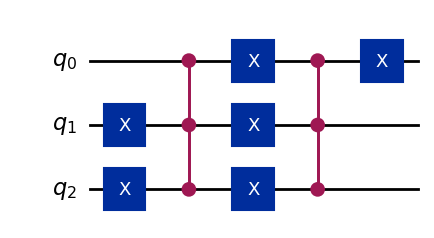

In [6]:
# Instantiation 
marked_states = ['001', '110']

oracle = grover_oracle(marked_states)
oracle.draw(output = "mpl")

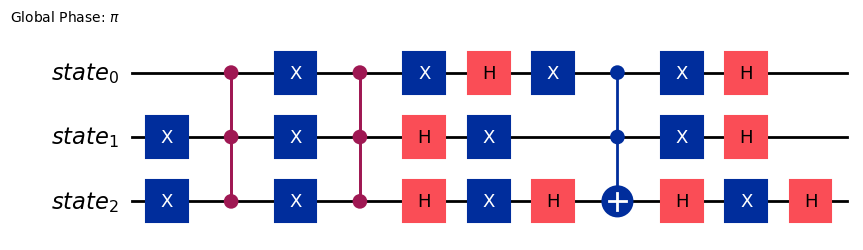

In [7]:
# Grover Operator
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [8]:
# Amplification 
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

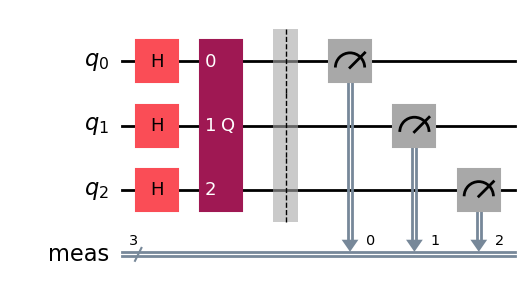

In [9]:
# Full Grover Circuit with amplification and all measurements
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace = True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

### Optimization for quantum execution

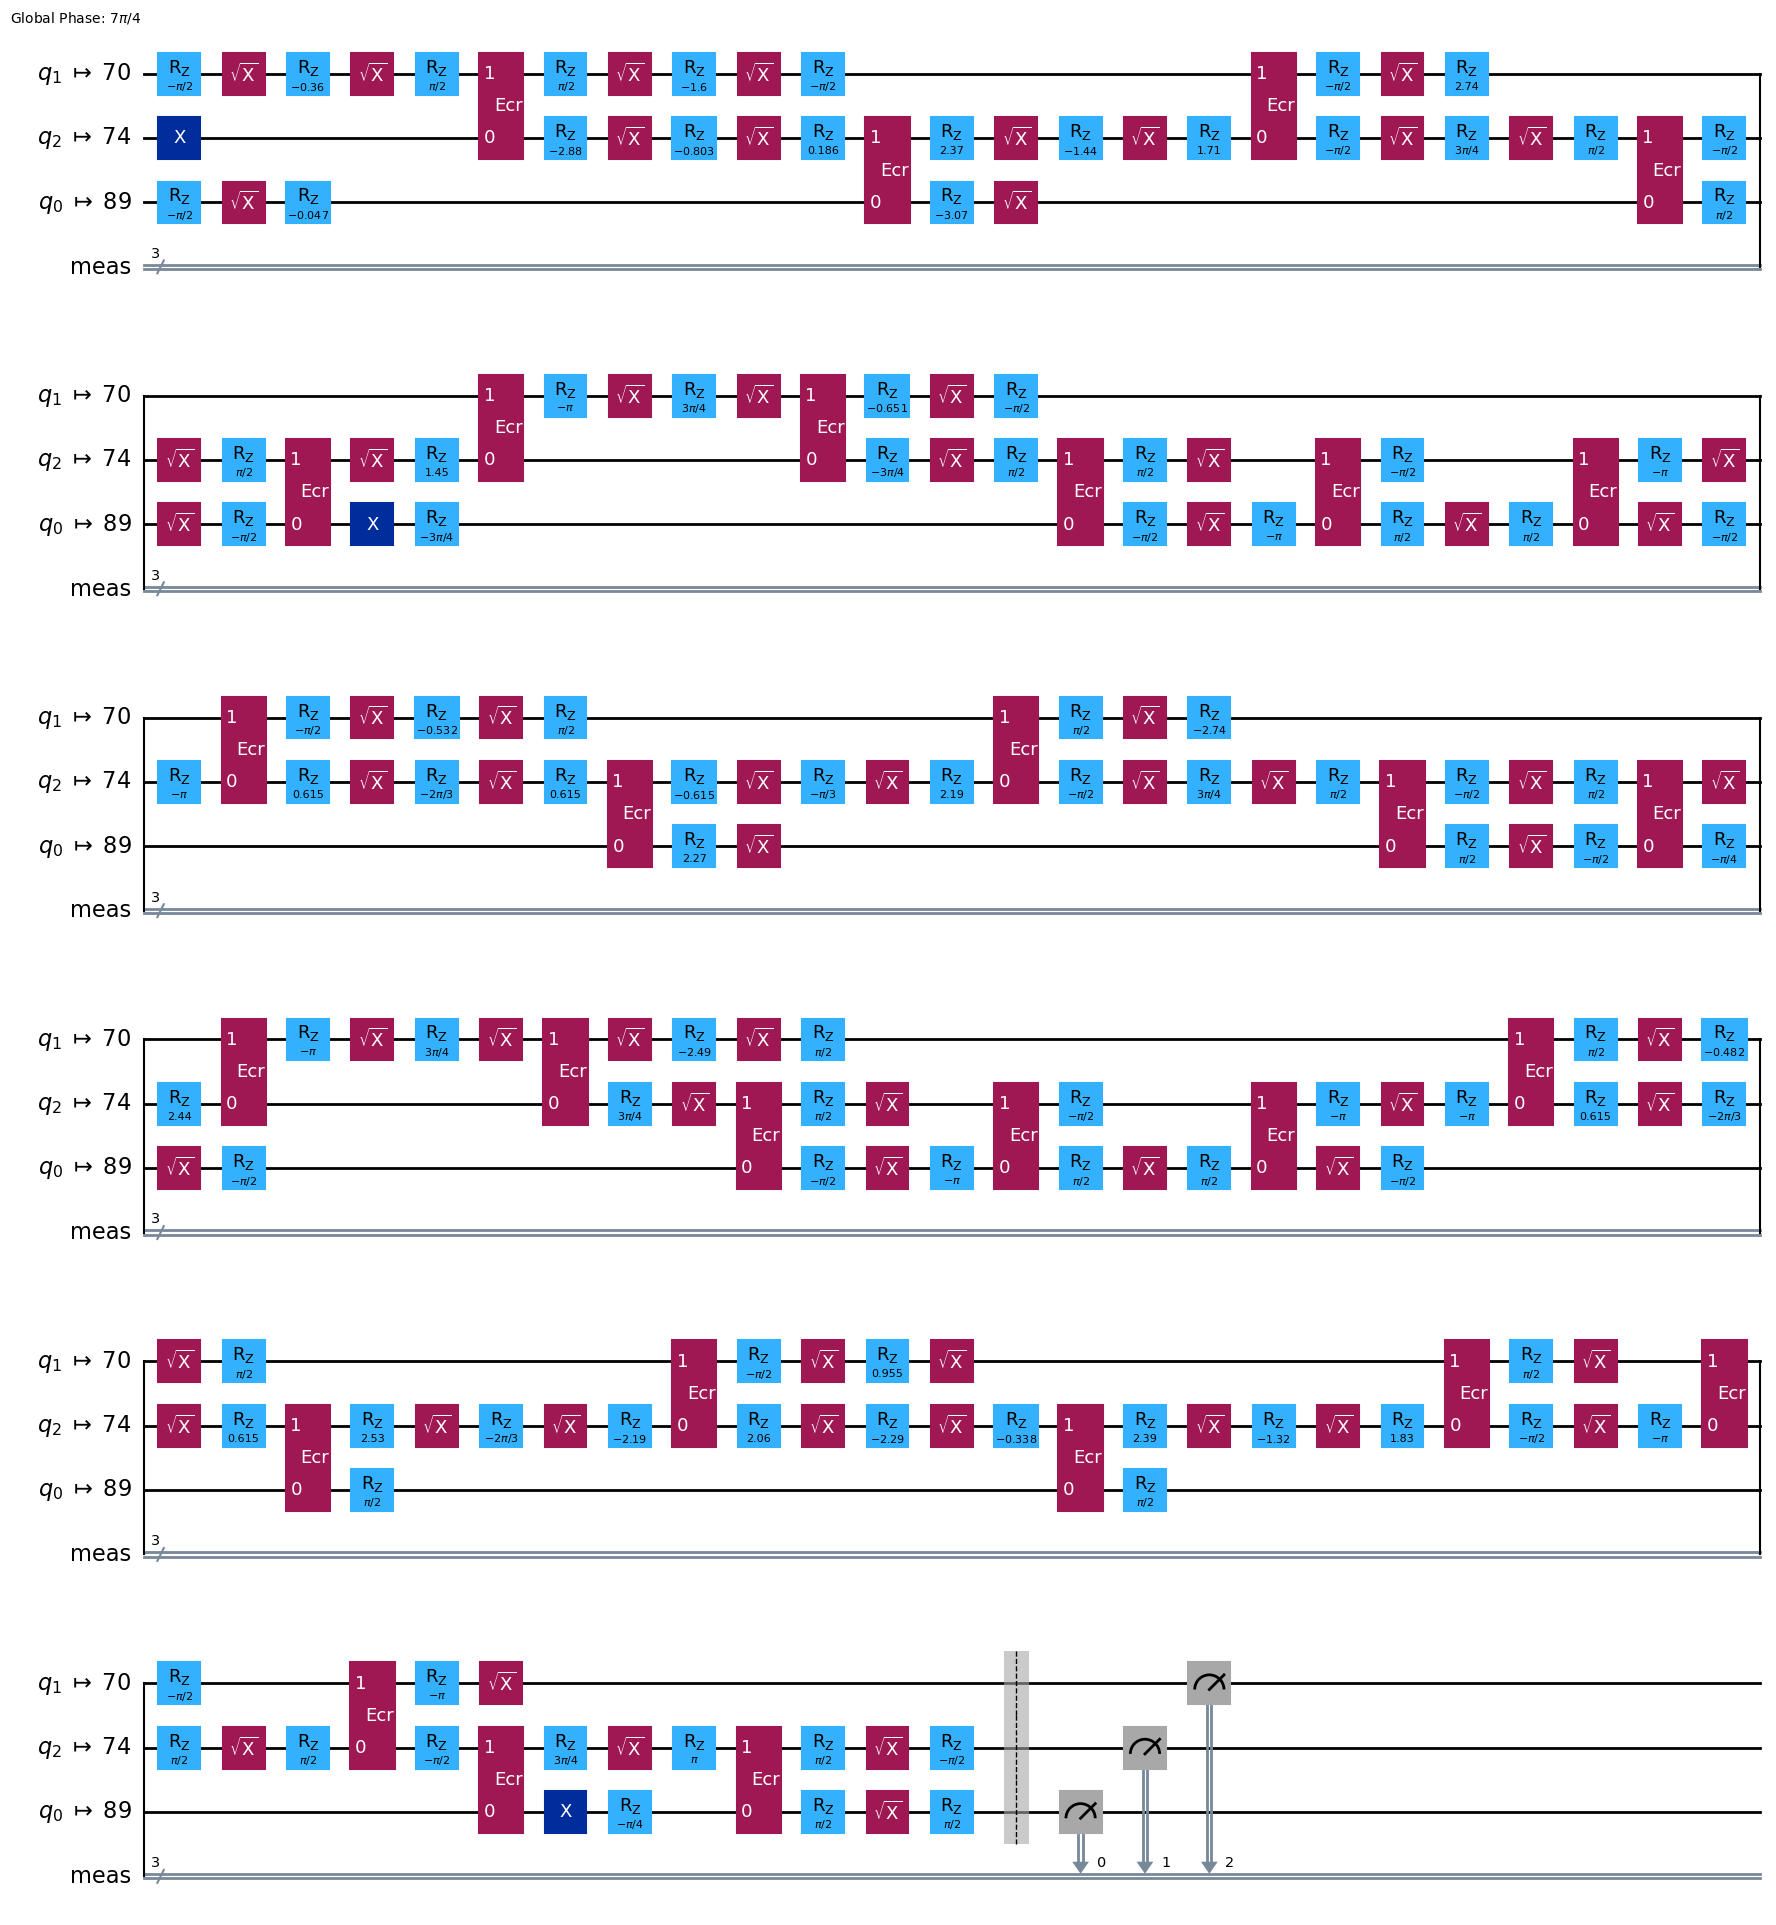

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target = target, optimization_level = 3)

grover_circ = pm.run(qc)
grover_circ.draw(output="mpl", idle_wires = False, style="iqp")

### Execution using primitives

In [11]:
# Running on a local simulator
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([grover_circ]).result()
dist = result[0].data.meas.get_counts()

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_78579/372735606.py:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


### Post-processing 

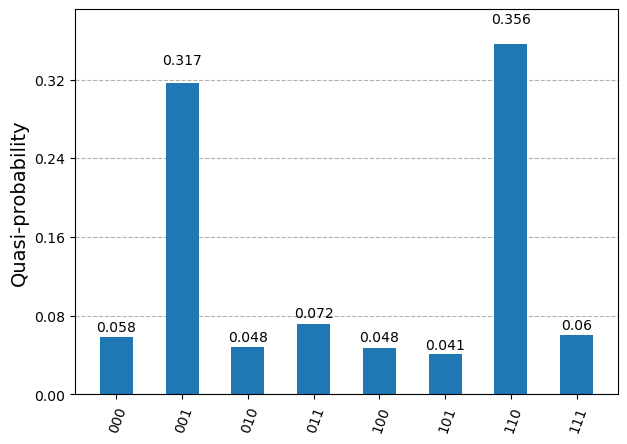

In [13]:
plot_distribution(dist)